# Projet Data

In [2]:
#!pip install pmdarima

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

# Charger le dataset
df = pd.read_csv('urgences_data.csv', encoding='latin1')

# Aperçu des premières lignes
df.head()

,date_heure_arrivee,id_passage,mois,heure,jour_semaine,annee,alerte_epidemique,temperature_max,indicateur_greve,evenement_externe,...,devenir_patient,temps_passage_total,date_heure_arrivee_encoded,alerte_epidemique_encoded,batiment_accueil_encoded,site_accueil_encoded,filiere_pathologie_encoded,mode_transport_encoded,besoin_imagerie_encoded,devenir_patient_encoded
0,01/11/2020 00:05,1000001,11,0,6,2020,Bronchiolite,15.983798,0,0,...,Retour Domicile,341,13518,1,1,0,4,0,1,1
1,01/11/2020 00:05,1000002,11,0,6,2020,Bronchiolite,15.983798,0,0,...,Retour Domicile,335,13518,1,1,0,6,0,1,1
2,01/11/2020 00:47,1000003,11,0,6,2020,Bronchiolite,12.006751,0,0,...,Transfert,254,13519,1,1,0,7,3,0,2
3,01/11/2020 00:54,1000004,11,0,6,2020,Bronchiolite,12.834808,0,0,...,Retour Domicile,298,13520,1,1,0,2,1,1,1
4,01/11/2020 01:24,1000005,11,1,6,2020,Bronchiolite,14.335864,0,0,...,Retour Domicile,228,13521,1,1,0,9,3,0,1


## Analyse exploratoire des données

In [4]:
# Dimensions, types de colonnes et mémoire
print(df.info())

# Statistiques descriptives (moyenne, quartiles, etc.)
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570282 entries, 0 to 570281
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   date_heure_arrivee          570282 non-null  object 
 1   id_passage                  570282 non-null  int64  
 2   mois                        570282 non-null  int64  
 3   heure                       570282 non-null  int64  
 4   jour_semaine                570282 non-null  int64  
 5   annee                       570282 non-null  int64  
 6   alerte_epidemique           570282 non-null  object 
 7   temperature_max             570282 non-null  float64
 8   indicateur_greve            570282 non-null  int64  
 9   evenement_externe           570282 non-null  int64  
 10  niveau_pollution            570282 non-null  int64  
 11  batiment_accueil            570282 non-null  object 
 12  site_accueil                570282 non-null  object 
 13  age_patient   

In [5]:
# Vérifier le nombre de valeurs nulles par colonne
print(df.isnull().sum())

# Supprimer les doublons
df = df.drop_duplicates()

date_heure_arrivee            0
id_passage                    0
mois                          0
heure                         0
jour_semaine                  0
annee                         0
alerte_epidemique             0
temperature_max               0
indicateur_greve              0
evenement_externe             0
niveau_pollution              0
batiment_accueil              0
site_accueil                  0
age_patient                   0
filiere_pathologie            0
score_IAO                     0
mode_transport                0
effectif_soignant_present     0
dispo_lits_aval               0
besoin_imagerie               0
consommation_O2               0
kit_traumatologie             0
solutes_hydratation           0
devenir_patient               0
temps_passage_total           0
date_heure_arrivee_encoded    0
alerte_epidemique_encoded     0
batiment_accueil_encoded      0
site_accueil_encoded          0
filiere_pathologie_encoded    0
mode_transport_encoded        0
besoin_i

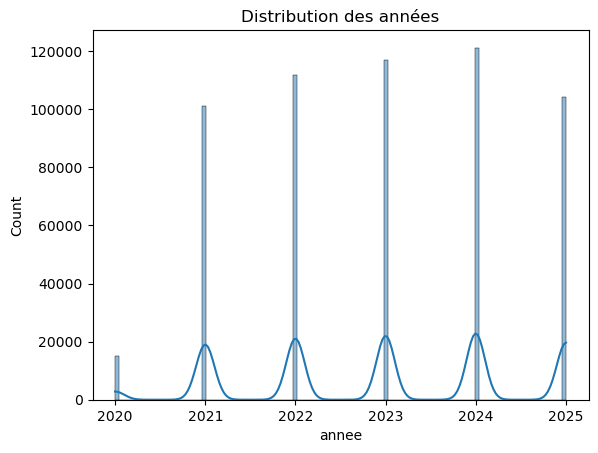

In [6]:
# Distribution d'une variable numérique
sns.histplot(df['annee'], kde=True)
plt.title('Distribution des années')
plt.show()

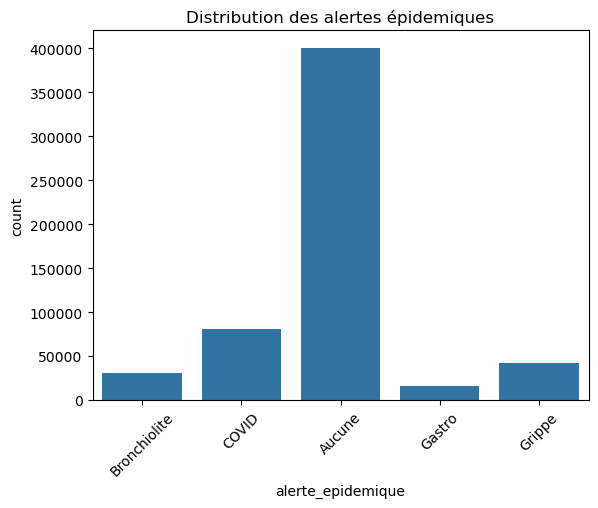

In [7]:
# Fréquence d'une variable catégorielle
sns.countplot(x='alerte_epidemique', data=df)
plt.xticks(rotation=45)
plt.title('Distribution des alertes épidemiques')
plt.show()

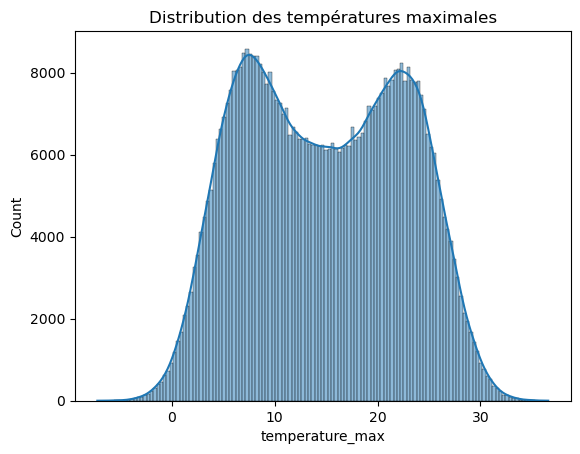

In [8]:
# Distribution d'une variable numérique
sns.histplot(df['temperature_max'], kde=True)
plt.title('Distribution des températures maximales')
plt.show()

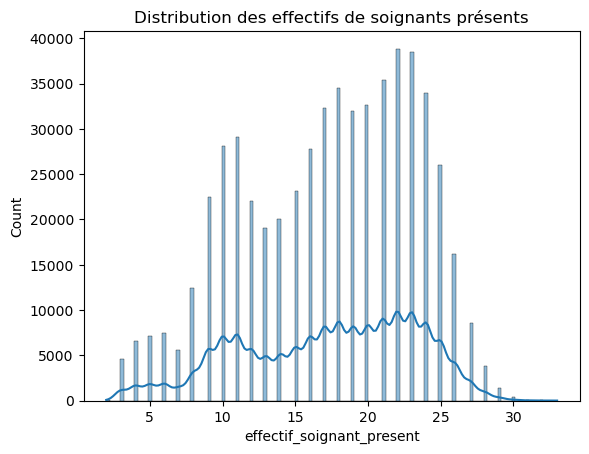

In [9]:
# Distribution d'une variable numérique
sns.histplot(df['effectif_soignant_present'], kde=True)
plt.title('Distribution des effectifs de soignants présents')
plt.show()

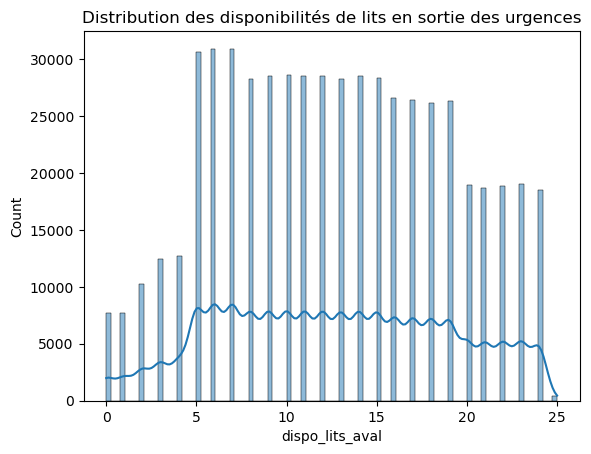

In [10]:
# Distribution d'une variable numérique
sns.histplot(df['dispo_lits_aval'], kde=True)
plt.title('Distribution des disponibilités de lits en sortie des urgences')
plt.show()

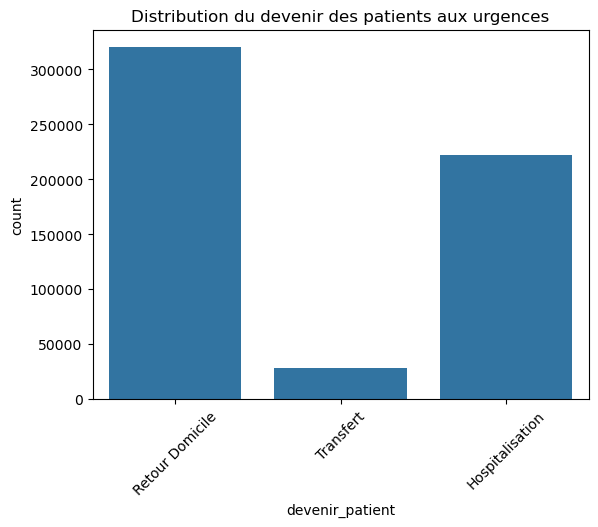

In [11]:
# Fréquence d'une variable catégorielle
sns.countplot(x='devenir_patient', data=df)
plt.xticks(rotation=45)
plt.title('Distribution du devenir des patients aux urgences')
plt.show()

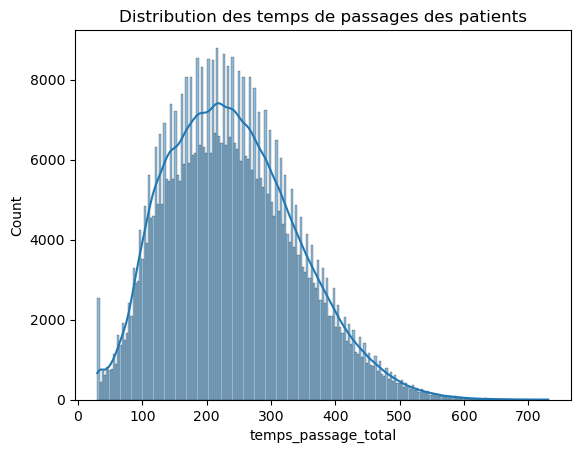

In [12]:
# Distribution d'une variable numérique
sns.histplot(df['temps_passage_total'], kde=True)
plt.title('Distribution des temps de passages des patients')
plt.show()

## Feature Engineering

In [14]:
# Conversion de la colonne en format datetime
df['date_heure_arrivee'] = pd.to_datetime(df['date_heure_arrivee'], format='%d/%m/%Y %H:%M')

# Fix the timestamp logic
# - Day part from original date
# - Hour part from 'heure' column
# - Minutes always '00'
df['date_hourly'] = df['date_heure_arrivee'].dt.normalize() + pd.to_timedelta(df['heure'], unit='h')

In [15]:
# Vérifier si c'est le week-end (souvent critique aux urgences)
df['est_weekend'] = (df['date_heure_arrivee'].dt.dayofweek >= 5).astype("int64")

# 1 si l'arrivée est entre 8h et 20h, sinon 0
df['heures_pleines'] = df['date_heure_arrivee'].dt.hour.between(8, 20).astype("int64")

In [16]:
# Estimer la date et l'heure de sortie
df["date_heure_sortie_estimee"] = (
    df["date_heure_arrivee"] + pd.to_timedelta(df["temps_passage_total"], unit="m")
)

# Create two dataframes: one for arrivals, one for exits
arrivals = pd.DataFrame({'time': df['date_heure_arrivee'], 'change': 1})
exits = pd.DataFrame({'time': df['date_heure_sortie_estimee'], 'change': -1})

# Combine and sort them by time
events = pd.concat([arrivals, exits]).sort_values(by='time')

# Calculate the running total (cumulative sum)
events['occupancy'] = events['change'].cumsum()

# Merge back to the original dataframe to get the count at arrival time
# 'merge_asof' is perfect here: it finds the occupancy state at the exact arrival moment
df = df.sort_values('date_heure_arrivee')
df = pd.merge_asof(
    df, 
    events[['time', 'occupancy']], 
    left_on='date_heure_arrivee', 
    right_on='time', 
    direction='backward'
)

# Final calculation
CAPACITE_LITS = 30
df["nb_patients_en_cours"] = df['occupancy']
df["occup_lits_estimee"] = df["nb_patients_en_cours"] / CAPACITE_LITS

df.head()

,date_heure_arrivee,id_passage,mois,heure,jour_semaine,annee,alerte_epidemique,temperature_max,indicateur_greve,evenement_externe,...,besoin_imagerie_encoded,devenir_patient_encoded,date_hourly,est_weekend,heures_pleines,date_heure_sortie_estimee,time,occupancy,nb_patients_en_cours,occup_lits_estimee
0,2020-11-01 00:05:00,1000001,11,0,6,2020,Bronchiolite,15.983798,0,0,...,1,1,2020-11-01 00:00:00,1,0,2020-11-01 05:46:00,2020-11-01 00:05:00,2,2,0.066667
1,2020-11-01 00:05:00,1000002,11,0,6,2020,Bronchiolite,15.983798,0,0,...,1,1,2020-11-01 00:00:00,1,0,2020-11-01 05:40:00,2020-11-01 00:05:00,2,2,0.066667
2,2020-11-01 00:47:00,1000003,11,0,6,2020,Bronchiolite,12.006751,0,0,...,0,2,2020-11-01 00:00:00,1,0,2020-11-01 05:01:00,2020-11-01 00:47:00,3,3,0.100000
3,2020-11-01 00:54:00,1000004,11,0,6,2020,Bronchiolite,12.834808,0,0,...,1,1,2020-11-01 00:00:00,1,0,2020-11-01 05:52:00,2020-11-01 00:54:00,4,4,0.133333
4,2020-11-01 01:24:00,1000005,11,1,6,2020,Bronchiolite,14.335864,0,0,...,0,1,2020-11-01 01:00:00,1,0,2020-11-01 05:12:00,2020-11-01 01:24:00,5,5,0.166667


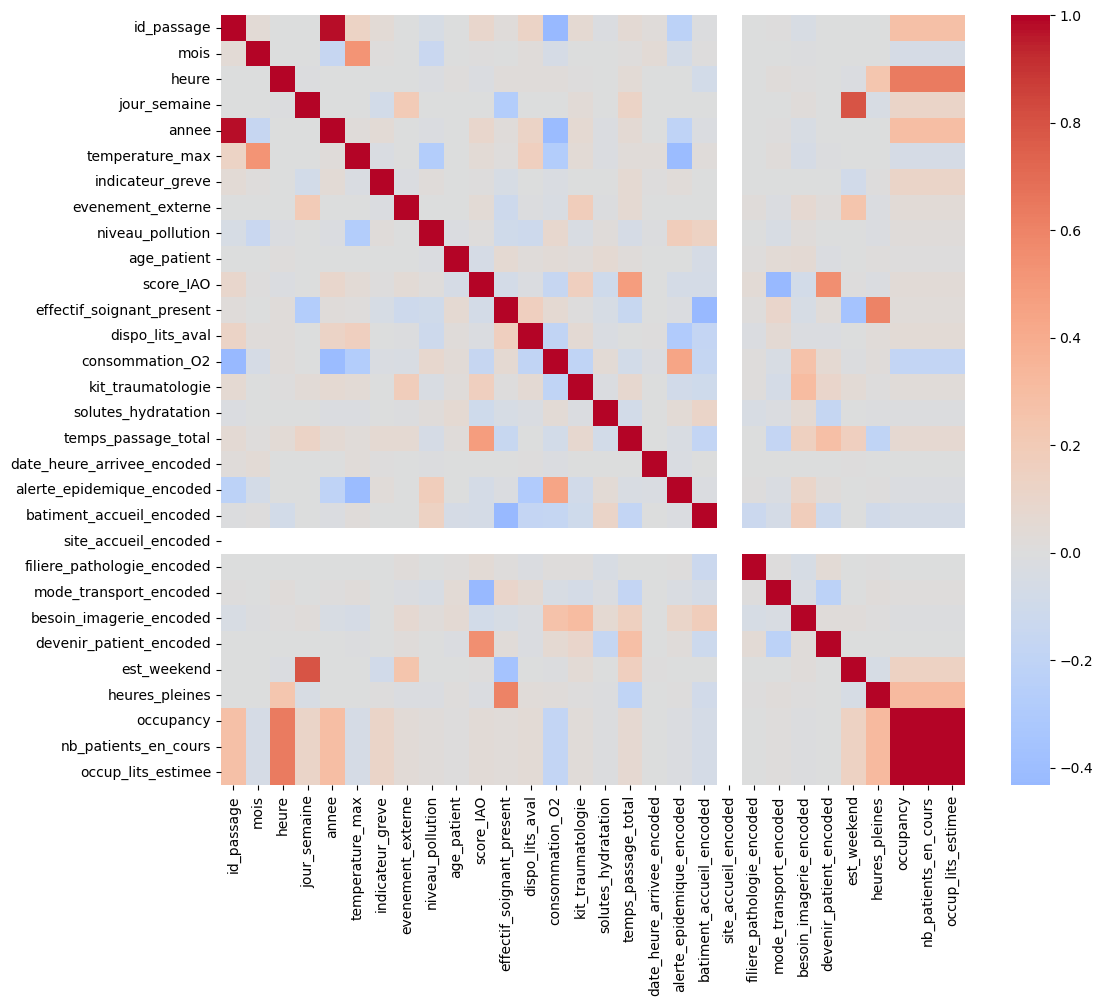

In [17]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
plt.figure(figsize=(12, 10))
sns.heatmap(df[num_cols].corr(), cmap="coolwarm", center=0)
plt.show()

In [18]:
# Set the index
df = df.set_index('date_hourly')

# Use resample('h') to make each row an HOUR
# We use .agg to calculate the Mean (duration) and the Count (patients) simultaneously
df_hourly = df.resample('h').agg({
    'id_passage': 'count',          # The number of patients for that hour
    'temps_passage_total': 'mean',  # The average duration for that hour
    'mois': 'mean',
    'heure': 'mean',
    'jour_semaine': 'mean',
    'annee': 'mean',
    'temperature_max': 'max',
    'indicateur_greve': 'max',
    'evenement_externe': 'max',
    'niveau_pollution': 'max',
    'age_patient': 'mean',
    'score_IAO': 'max',
    'effectif_soignant_present': 'mean',
    'dispo_lits_aval': 'min',
    'consommation_O2': 'min',
    'kit_traumatologie': 'min',
    'solutes_hydratation': 'min',
    'alerte_epidemique_encoded': 'mean',
    'batiment_accueil_encoded': 'mean',
    'site_accueil_encoded': 'mean',
    'filiere_pathologie_encoded': 'mean',
    'mode_transport_encoded': 'mean',
    'besoin_imagerie_encoded': 'mean',
    'devenir_patient_encoded': 'mean',
    'est_weekend': 'max',
    'heures_pleines': 'max',
    'nb_patients_en_cours': 'max',
    'occup_lits_estimee': 'max'
}).rename(columns={
    'temps_passage_total': 'avg_passage_time',
    'id_passage': 'patient_count'
})


# Handle NaNs (required for SARIMAX and before casting to int)
df_hourly['patient_count'] = df_hourly['patient_count'].fillna(0)
# Forward fill to handle hours with no patients
df_hourly = df_hourly.ffill().bfill()

# Identify all columns that end with '_encoded'
encoded_cols = [col for col in df_hourly.columns if col.endswith('_encoded')]
# Apply rounding and integer casting to all of them
df_hourly[encoded_cols] = df_hourly[encoded_cols].round().astype(int)

df_hourly.head()

,patient_count,avg_passage_time,mois,heure,jour_semaine,annee,temperature_max,indicateur_greve,evenement_externe,niveau_pollution,...,batiment_accueil_encoded,site_accueil_encoded,filiere_pathologie_encoded,mode_transport_encoded,besoin_imagerie_encoded,devenir_patient_encoded,est_weekend,heures_pleines,nb_patients_en_cours,occup_lits_estimee
date_hourly,,,,,,,,,,,,,,,,,,,,,
2020-11-01 00:00:00,4,307.000000,11.0,0.0,6.0,2020.0,15.983798,0.0,0.0,5.0,...,1,0,5,1,1,1,1.0,0.0,4.0,0.133333
2020-11-01 01:00:00,3,263.666667,11.0,1.0,6.0,2020.0,16.753026,0.0,0.0,7.0,...,1,0,9,2,1,1,1.0,0.0,7.0,0.233333
2020-11-01 02:00:00,6,201.000000,11.0,2.0,6.0,2020.0,21.034677,0.0,0.0,5.0,...,2,0,5,2,0,1,1.0,0.0,13.0,0.433333
2020-11-01 03:00:00,3,269.333333,11.0,3.0,6.0,2020.0,16.628042,0.0,0.0,4.0,...,1,0,7,2,1,1,1.0,0.0,16.0,0.533333
2020-11-01 04:00:00,4,187.250000,11.0,4.0,6.0,2020.0,17.000000,0.0,0.0,9.0,...,2,0,7,2,1,0,1.0,0.0,18.0,0.600000


In [19]:
# Calcul du point de scission
split_index = int(len(df_hourly) * 0.8)

# Découpage chronologique
train = df_hourly.iloc[:split_index]
test = df_hourly.iloc[split_index:]

print(f"Total créneaux horaires : {len(df_hourly)}")
print(f"Train set (80%)   : {len(train)}")
print(f"Test set (20%)    : {len(test)}")

Total créneaux horaires : 43824
Train set (80%)   : 35059
Test set (20%)    : 8765


## Modèle de prédiction SARIMAX

### Test d'Augmented Dickey-Fuller (ADF)

In [22]:
def run_adf_test(series):
    print(f"Résultats du test de Dickey-Fuller pour la série : {series.name}")
    result = adfuller(series)
    
    labels = [
        'Statistique de test', 
        'p-value', 
        'Nombre de retards utilisés', 
        'Nombre d\'observations'
    ]
    
    for value, label in zip(result, labels):
        print(f'{label} : {value}')

    for key, value in result[4].items():
        print(f'Valeur critique ({key}) : {value}')

    if result[1] <= 0.05:
        print("\nConclusion : On rejette l'hypothèse nulle (H0). La série est stationnaire.")
    else:
        print("\nConclusion : On ne peut pas rejeter l'hypothèse nulle (H0). La série n'est pas stationnaire.")

# Tester la stationnarité du temps de passage moyen
run_adf_test(df_hourly['avg_passage_time'])

Résultats du test de Dickey-Fuller pour la série : avg_passage_time
Statistique de test : -20.459032765861895
p-value : 0.0
Nombre de retards utilisés : 55
Nombre d'observations : 43768
Valeur critique (1%) : -3.4304994170070295
Valeur critique (5%) : -2.861606039041269
Valeur critique (10%) : -2.5668051504336344

Conclusion : On rejette l'hypothèse nulle (H0). La série est stationnaire.


### Définition de la variable cible et des valeurs exogènes

In [24]:
# Définition de la variable cible et des variables explicatives
y_train = train['avg_passage_time']
exog_train = train[['jour_semaine', 'effectif_soignant_present', 'consommation_O2', 'dispo_lits_aval', 'filiere_pathologie_encoded', 'besoin_imagerie_encoded', 'est_weekend', 'heures_pleines', 'nb_patients_en_cours', 'occup_lits_estimee']]

y_test = test['avg_passage_time']
exog_test = test[['jour_semaine', 'effectif_soignant_present', 'consommation_O2', 'dispo_lits_aval', 'filiere_pathologie_encoded', 'besoin_imagerie_encoded', 'est_weekend', 'heures_pleines', 'nb_patients_en_cours', 'occup_lits_estimee']]

### Modèle simple

In [ ]:
# Définition du modèle
model_simple = SARIMAX(y_train, 
                exog=exog_train, 
                order=(1, 1, 1), 
                seasonal_order=(1, 1, 1, 24), # Cycle de 24h
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model_simple.fit()

# Affichage des statistiques (chercher un AIC faible)
print(results.summary())

# Diagnostic des résidus (vérifier qu'ils ressemblent à un bruit blanc)
results.plot_diagnostics(figsize=(12, 8))
plt.show()

In [ ]:
# Définition du modèle
model_simple = SARIMAX(y_train, 
                exog=exog_train, 
                order=(1, 1, 1), 
                seasonal_order=(1, 1, 1, 168), # Cycle de 7j
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model_simple.fit()

# Affichage des statistiques (chercher un AIC faible)
print(results.summary())

# Diagnostic des résidus (vérifier qu'ils ressemblent à un bruit blanc)
results.plot_diagnostics(figsize=(12, 8))
plt.show()

In [ ]:
# pred = results.get_forecast(steps=len(test), exog=exog_test)
# pred_ci = pred.conf_int() # Intervalle de confiance

# Visualisation
# ax = y.plot(label='Observé')
# pred.predicted_mean.plot(ax=ax, label='Prédiction SARIMAX', color='red')
# ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='pink', alpha=0.3)
# plt.legend()
# plt.show()

### Modèle avec AutoARIMA

In [ ]:
# Configuration de l'Auto-ARIMA
model_auto = pm.auto_arima(
    y_train, 
    seasonal=True,           # Active la composante saisonnière
    m=24,                     # Fréquence saisonnière
    stepwise=True,           # Utilise un algorithme plus rapide pour chercher les paramètres
    suppress_warnings=True, 
    error_action="ignore", 
    trace=True               # Affiche les combinaisons testées
)

model_auto.summary()

In [ ]:
# Récupération des ordres trouvés par Auto-ARIMA
order = model_auto.order           # (p, d, q)
seasonal_order = model_auto.seasonal_order # (P, D, Q, s)

# Création du modèle SARIMAX (avec optionnelles exogènes)
model = SARIMAX(
    y_train,
    exog=exog_train,        # Ajoute tes variables externes ici si besoin
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_results = model.fit()
sarima_results.summary()

In [ ]:
# Configuration de l'Auto-ARIMA
model_auto = pm.auto_arima(
    y_train, 
    seasonal=True,           # Active la composante saisonnière
    m=168,                     # Fréquence saisonnière
    stepwise=True,           # Utilise un algorithme plus rapide pour chercher les paramètres
    suppress_warnings=True, 
    error_action="ignore", 
    trace=True               # Affiche les combinaisons testées
)

model_auto.summary()

In [ ]:
# Récupération des ordres trouvés par Auto-ARIMA
order = model_auto.order           # (p, d, q)
seasonal_order = model_auto.seasonal_order # (P, D, Q, s)

# Création du modèle SARIMAX (avec optionnelles exogènes)
model = SARIMAX(
    y_train,
    exog=exog_train,        # Ajoute tes variables externes ici si besoin
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_results = model.fit()
sarima_results.summary()